# HW4 — PCA + CRC on LFW

### Imports

In [36]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.dpi'] = 120
print('Imports ok.')

Imports ok.


## 1) Load LFW (min_faces_per_person=50) and flatten
- We use `resize=0.4` (as in the scikit-learn example).
- This starter filters identities with **≥ 50 images** (handled by `min_faces_per_person`).

In [37]:
lfw = fetch_lfw_people(min_faces_per_person=50, resize=0.4, color=False)
X_images = lfw.images                 # (n_samples, h, w)
X = lfw.data.astype(np.float32)       # (n_samples, h*w)
y = lfw.target                        # integer labels
target_names = lfw.target_names       # label -> name mapping
h, w = lfw.images.shape[1:3]

print('Images:', X_images.shape, '| Flattened:', X.shape, '| Labels:', y.shape)
print('Num classes:', len(target_names), 'Names:', list(target_names))

Images: (1560, 50, 37) | Flattened: (1560, 1850) | Labels: (1560,)
Num classes: 12 Names: ['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac', 'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi', 'Serena Williams', 'Tony Blair']


## 2) Visualizing a few samples

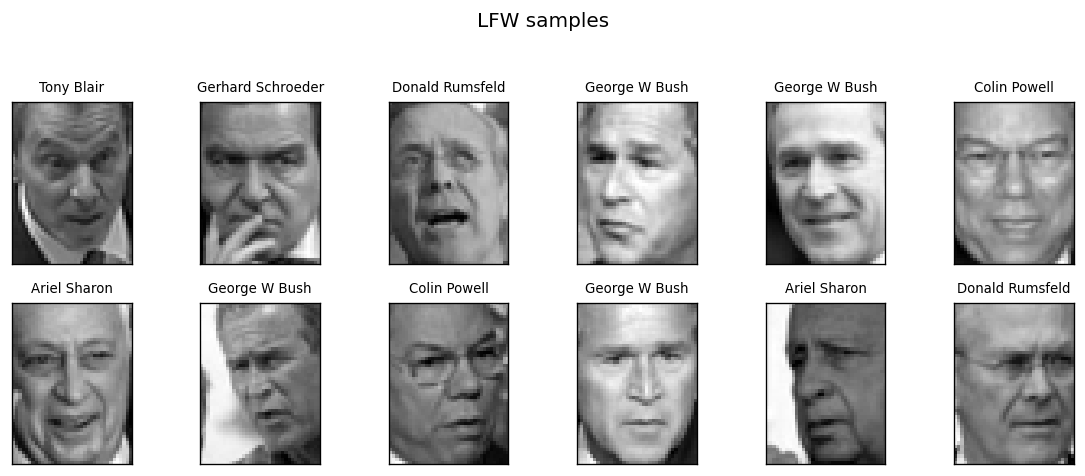

In [38]:
def plot_faces(images, labels, label_names, n_row=2, n_col=6, title=None):
    plt.figure(figsize=(1.6*n_col, 2.0*n_row))
    if title: plt.suptitle(title)
    for i in range(n_row*n_col):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.imshow(images[i], cmap='gray')
        ax.set_title(str(label_names[labels[i]]), fontsize=8)
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

plot_faces(X_images[:12], y[:12], target_names, n_row=2, n_col=6, title='LFW samples')

## 3) Stratified split: 60% train / 15% val / 25% test
We do it in two stages to preserve class balance with a fixed seed:
1. Train+Val vs Test (75/25)
2. Train vs Val (80/20) -> overall 60/15/25.

In [39]:
X_trval, X_te, y_trval, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_trval, y_trval, test_size=0.20, stratify=y_trval, random_state=RANDOM_STATE
)
print('Train:', X_tr.shape, '| Val:', X_val.shape, '| Test:', X_te.shape)

Train: (936, 1850) | Val: (234, 1850) | Test: (390, 1850)


## 4) Preprocessing helpers
- **Standardize** using **TRAIN** stats only.
- **ℓ2-normalize rows** (common in representation classifiers).

In [40]:
def fit_standardize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=1)
    sigma[sigma < 1e-8] = 1e-8
    return mu, sigma

def apply_standardize(X, mu, sigma):
    return (X - mu) / sigma

def l2_normalize_rows(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms < 1e-12] = 1e-12
    return X / norms

# Compute TRAIN stats and standardize all splits
mu_tr, sig_tr = fit_standardize(X_tr)
Xtr_std = apply_standardize(X_tr, mu_tr, sig_tr)
Xval_std = apply_standardize(X_val, mu_tr, sig_tr)
Xte_std  = apply_standardize(X_te,  mu_tr, sig_tr)

# Optionally ℓ2-normalize rows (useful for CRC)
Xtr_proc = l2_normalize_rows(Xtr_std)
Xval_proc = l2_normalize_rows(Xval_std)
Xte_proc  = l2_normalize_rows(Xte_std)
print('Preprocessing ready.')

Preprocessing ready.


## 5) PCA from scratch via SVD
**Implement the following:**
1. `pca_fit_svd(X_train_centered)`: fits PCA on centered TRAIN data using `np.linalg.svd`.
2. `pca_choose_k_from_ratio(evr, target_ratio)`: picks k from cumulative variance ratio.
3. Projects **train/val/test** with the top-\(k\) components.

In [41]:
# Fiting PCA via SVD on centered TRAIN data.
# Returning components (Vt), singular_values (S), explained_variance, explained_variance_ratio.
def pca_fit_svd(X):
    n = X.shape[0]
    u, s, Vt = np.linalg.svd(X, full_matrices=False)
    explained_variance = (s**2) / (n-1)
    explained_variance_ratio = explained_variance / explained_variance.sum()
    return Vt, s, explained_variance, explained_variance_ratio


# Returning smallest k with cumulative EVR >= target_ratio.
# aka choosing the first k eigenvectors that sub to >= target
def pca_choose_k_from_ratio(evr, target_ratio=0.95):
    sum = np.cumsum(evr)
    k = np.searchsorted(sum, target_ratio) + 1
    k = min(k, len(evr))
    return k

# Fiting PCA on TRAIN (centered), choosing k from ratio, project TR/VAL/TE.
# Returns Z_tr, Z_val, Z_te, components_k, k
# Centering TRAIN (after standardization)
def pca_project_splits(Xtr_std, Xval_std, Xte_std, target_ratio=0.95):
    mean = Xtr_std.mean(axis=0)
    X = Xtr_std - mean
    Vt, S, ev, evr = pca_fit_svd(X)

    k = pca_choose_k_from_ratio(evr, target_ratio)
    Vt = Vt[:k]

    Xtr = (Xtr_std - mean) @ Vt.T
    Xval = (Xval_std - mean) @ Vt.T
    Xte = (Xte_std - mean) @ Vt.T

    return Xtr, Xval, Xte, Vt, k

## 6) CRC (Collaborative Representation Classifier)

1. `crc_precompute(D, lam)`: with **columns** of `D` as training samples, compute
   \[ P = (D^T D + \lambda I)^{-1} D^T. \]
   (Use `np.linalg.solve` instead of explicit matrix inverse.)
2. `crc_predict_one(P, D, y_vec, y_tr, classes)`: compute collaborative coefficients \(\alpha=P y\),
   then pick the class with smallest residual \(\|y - D_c \alpha_c\|_2\).
3. `crc_predict_set(...)`: loop over a set of samples.


In [42]:
# Returns P = (D^T D + lam I)^{-1} D^T using np.linalg.solve.
# D: (d, n_tr)
def crc_precompute(D, lam):
    d, n, = D.shape
    DtD = D.T @ D
    P = np.linalg.solve(DtD + lam * np.eye(n), D.T)
    return P

# Returns predicted class for a single sample by residual per class.
def crc_predict_one(P, D, y_vec, y_tr, classes):
    a = P @ y_vec
    residuals = []
    for c in classes:
        mask = y_tr == c
        D_c = D[:, mask]
        a_c = a[mask]
        reconstruction = D_c @ a_c
        residual = np.linalg.norm(y_vec - reconstruction)
        residuals.append(residual)

    return classes[np.argmin(residuals)]

# Predicts labels for all rows in X_set using crc_predict_one    
def crc_predict_set(P, D, X_set, y_tr, classes):
    predictions = []
    for i in range(X_set.shape[0]):
        y_vec = X_set[i]
        pred = crc_predict_one(P, D, y_vec, y_tr, classes)
        predictions.append(pred)
    return np.array(predictions)

## 7) Baseline: CRC without PCA (tuning lambda on validation)

1. Building `D` from **Xtr_proc** (columns are training samples).
2. Trying a grid of \(\lambda\) values (e.g., `[1e-3, 1e-2, 1e-1, 1, 10]`).
3. Picking the best-\(\lambda\) by **validation accuracy**.
4. Retraining CRC on **train+val** with that \(\lambda\), then evaluate once on **test**.

Recording results for my report.

In [43]:
lambdas = [1e-3, 1e-2, 1e-1, 1, 10]
D = Xtr_proc.T   # dictionary (d, n_tr)
classes = np.unique(y_tr)

best_no_pca = None
best_lam_no_pca = None

for lam in lambdas:
    # TODO: compute P, predict on validation, compute accuracy
    P = crc_precompute(D, lam)
    preds_val = crc_predict_set(P, D, Xval_proc, y_tr, classes)
    acc_val = accuracy_score(y_val, preds_val)
    print(f"[CRC no PCA] lambda={lam:>6g} | Val Acc={acc_val:.4f}")
    
    if (best_no_pca is None) or (acc_val > best_no_pca['val_acc']):
        best_no_pca = {'val_acc': acc_val, 'lam': lam}
        best_lam_no_pca = lam
    
# TODO: set best_lam_no_pca and best_no_pca dict
print(f"Best (no PCA): lambda={best_lam_no_pca} | Val Acc={best_no_pca['val_acc']:.4f}")

# TODO: Retrain with TRAIN+VAL and evaluate once on TEST
Xtrval_proc = l2_normalize_rows(apply_standardize(np.vstack([X_tr, X_val]), mu_tr, sig_tr))
y_trval = np.hstack([y_tr, y_val])
D_trval = Xtrval_proc.T
P_best = crc_precompute(D_trval, best_lam_no_pca)
test_preds_no_pca = crc_predict_set(P_best, D_trval, Xte_proc, y_trval, np.unique(y_trval))
test_acc_no_pca = accuracy_score(y_te, test_preds_no_pca)
print(f"[CRC no PCA] Retrained on TR+VAL -> Test Acc={test_acc_no_pca:.4f}")

[CRC no PCA] lambda= 0.001 | Val Acc=0.4274
[CRC no PCA] lambda=  0.01 | Val Acc=0.4829
[CRC no PCA] lambda=   0.1 | Val Acc=0.5085
[CRC no PCA] lambda=     1 | Val Acc=0.4359
[CRC no PCA] lambda=    10 | Val Acc=0.3462
Best (no PCA): lambda=0.1 | Val Acc=0.5085
[CRC no PCA] Retrained on TR+VAL -> Test Acc=0.4821
Fill in the CRC no-PCA experiment above.


## 8) CRC with PCA (tune variance ratio and lambda on validation)

1. Fitting PCA on **TRAIN** (standardized + centered) to get components and EVR (using my functions).
2. Trying a small set of target ratios, e.g. `[0.90, 0.95, 0.99]`.
3. For each ratio, projecting train/val/test to **Z**-space (top-\(k\) components).
4. ℓ2-normalize rows, build dictionary `Dk` from `Z_tr.T`.
5. Tune \(\lambda\) on **val**; picking best ratio and \(\lambda\).
6. Retraining PCA+CRC on **train+val** with best settings; test once.

Record results for your report and compare with the no-PCA baseline (use the **same split**!).

[CRC + PCA] ratio=0.90 (k=82) lambda= 0.001 | Val Acc=0.4359
[CRC + PCA] ratio=0.90 (k=82) lambda=  0.01 | Val Acc=0.4359
[CRC + PCA] ratio=0.90 (k=82) lambda=   0.1 | Val Acc=0.4359
[CRC + PCA] ratio=0.90 (k=82) lambda=     1 | Val Acc=0.4274
[CRC + PCA] ratio=0.90 (k=82) lambda=    10 | Val Acc=0.3504
[CRC + PCA] ratio=0.95 (k=155) lambda= 0.001 | Val Acc=0.4744
[CRC + PCA] ratio=0.95 (k=155) lambda=  0.01 | Val Acc=0.4744
[CRC + PCA] ratio=0.95 (k=155) lambda=   0.1 | Val Acc=0.4701
[CRC + PCA] ratio=0.95 (k=155) lambda=     1 | Val Acc=0.4359
[CRC + PCA] ratio=0.95 (k=155) lambda=    10 | Val Acc=0.3504
[CRC + PCA] ratio=0.99 (k=374) lambda= 0.001 | Val Acc=0.4957
[CRC + PCA] ratio=0.99 (k=374) lambda=  0.01 | Val Acc=0.4915
[CRC + PCA] ratio=0.99 (k=374) lambda=   0.1 | Val Acc=0.4872
[CRC + PCA] ratio=0.99 (k=374) lambda=     1 | Val Acc=0.4316
[CRC + PCA] ratio=0.99 (k=374) lambda=    10 | Val Acc=0.3462
[CRC + PCA] Test Acc=0.5077


Final Results:

CRC no PCA:
  Best lambda = 0

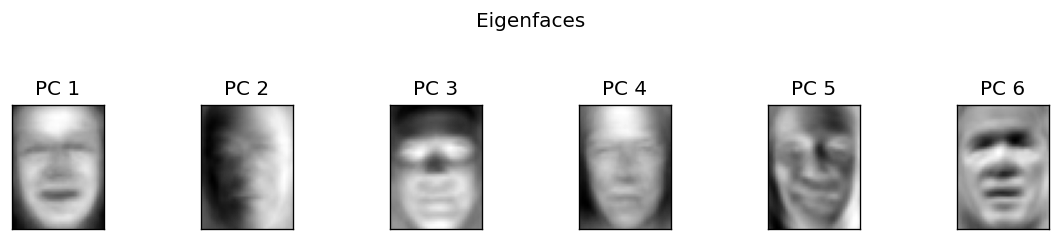

In [44]:
ratios = [0.90, 0.95, 0.99]
lambdas = [1e-3, 1e-2, 1e-1, 1, 10]

# Fiting PCA on TRAIN (centered). Example guidance (uncomment after you implement PCA):
Xtr_centered = Xtr_std - Xtr_std.mean(axis=0)
components, S, ev, evr = pca_fit_svd(Xtr_centered)

best_pca = None
best_params_pca = None

# choosing k from ratio, project TR/VAL/TE to Z-space using TRAIN mean & top-k comps
for ratio in ratios:
    Z_tr, Z_val, Z_te, comps_k, k = pca_project_splits(Xtr_std, Xval_std, Xte_std, target_ratio=ratio)
    Z_tr = l2_normalize_rows(Z_tr); Z_val = l2_normalize_rows(Z_val); Z_te = l2_normalize_rows(Z_te)
    Dk = Z_tr.T
    for lam in lambdas:
        Pk = crc_precompute(Dk, lam)
        preds_val = crc_predict_set(Pk, Dk, Z_val, y_tr, classes)
        acc_val = accuracy_score(y_val, preds_val)
        print(f"[CRC + PCA] ratio={ratio:.2f} (k={k}) lambda={lam:>6g} | Val Acc={acc_val:.4f}")
        if (best_pca is None) or (acc_val > best_pca['val_acc']):
            best_pca = {'val_acc': acc_val, 'lam': lam, 'ratio': ratio, 'k': k}
            best_params_pca = (ratio, k, lam)

# Retraining best PCA+CRC on TRAIN+VAL, evaluate on TEST
ratio_star, k_star, lam_star = best_params_pca

# creating the combined train+val dataset
Xtrval = np.vstack([X_tr, X_val])  # ← THIS WAS MISSING!
y_trval = np.hstack([y_tr, y_val])

# Computing new statistics on train+val
mu_trval, sig_trval = fit_standardize(Xtrval)
Xtrval_std = apply_standardize(Xtrval, mu_trval, sig_trval)
Xte_std_trval = apply_standardize(X_te, mu_trval, sig_trval)

# Projecting with the best ratio
(Z_trval, _, Z_te_final, comps_k_star, k_star) = pca_project_splits(Xtrval_std, Xte_std_trval, Xte_std_trval, target_ratio=ratio_star)
Z_trval = l2_normalize_rows(Z_trval)
Z_te_final = l2_normalize_rows(Z_te_final)


# Training final CRC model
D_trval_pca = Z_trval.T
P_best_pca = crc_precompute(D_trval_pca, lam_star)
test_preds_pca = crc_predict_set(P_best_pca, D_trval_pca, Z_te_final, 
                                  y_trval, np.unique(y_trval))
test_acc_pca = accuracy_score(y_te, test_preds_pca)
print(f"[CRC + PCA] Test Acc={test_acc_pca:.4f}")

# outputting Results
print(f"\n\nFinal Results:")
print(f"\nCRC no PCA:")
print(f"  Best lambda = {best_lam_no_pca}")
print(f"  Validation Acc = {best_no_pca['val_acc']:.4f}")
print(f"  Test Acc = {test_acc_no_pca:.4f}")

print(f"\nCRC With PCA:")
print(f"  Best variance ratio = {best_pca['ratio']:.2f}")
print(f"  Components (k) = {best_pca['k']}")
print(f"  Best lambda = {best_pca['lam']}")
print(f"  Validation Acc = {best_pca['val_acc']:.4f}")
print(f"  Test Acc = {test_acc_pca:.4f}")

print(f"\nAccuracy Improvement: {(test_acc_pca - test_acc_no_pca)*100:.2f}%")
print(f"Dimensionality Reduction: {X_tr.shape[1]} -> {best_pca['k']} ({100*best_pca['k']/X_tr.shape[1]:.1f}%)")


print(f"\n\nVariance Ratio - Number of Components")
print(f"{'Variance Ratio':<20} {'k (components)':<15} {'% of total'}")

for ratio in ratios:
    k = pca_choose_k_from_ratio(evr, target_ratio=ratio)
    pct = 100 * k / len(evr)
    print(f"{ratio:<20.2f} {k:<15d} {pct:.1f}%")


# Plotting eigenfaces
def plot_eigenfaces(components, h, w, n=6):
    plt.figure(figsize=(1.6*n, 2.0))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        ax.imshow(components[i].reshape(h, w), cmap='gray')
        ax.set_title(f"PC {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle("Eigenfaces")
    plt.tight_layout(rect=[0,0,1,0.9])
    plt.show()

plot_eigenfaces(comps_k_star, h, w)

## 9) Confusion matrix plots
You can visualize the test confusion matrices for the no-PCA and with-PCA models (if you computed predictions).

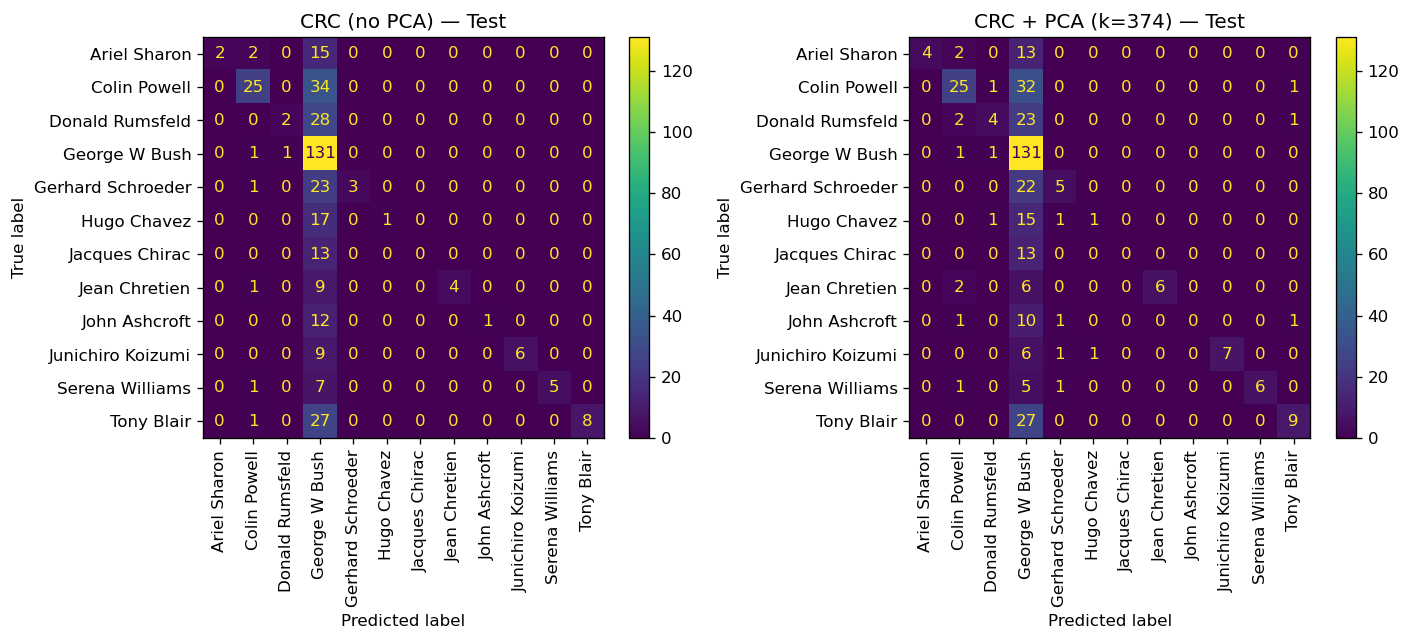

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_te, test_preds_no_pca, display_labels=target_names, xticks_rotation=90, ax=ax[0])
ax[0].set_title('CRC (no PCA) — Test')
ConfusionMatrixDisplay.from_predictions(y_te, test_preds_pca, display_labels=target_names, xticks_rotation=90, ax=ax[1])
ax[1].set_title(f'CRC + PCA (k={best_pca["k"]}) — Test')
plt.tight_layout(); plt.show()